In [1]:
import pandas
import io
import numpy as np
import tensorflow
from tensorflow import keras
from keras.utils.data_utils import pad_sequences
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional,Input, Dropout, concatenate    
from keras.models import Model 
#from tensorflow.keras.layers import Input
#from keras_contrib.layers import CRF
from tqdm import tqdm 
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Nadam
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
import tensorflow_addons as tfa

c:\Users\HP\anaconda3\envs\tenserflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
data = pandas.read_excel('..\data\dataset4.xlsx')

In [9]:
data.Cumle.unique()

df_len_cumle = pandas.DataFrame(data = {"len_cumle" : data.groupby(by="Cumle").Kelime.count()})

max_len_cumle = df_len_cumle.len_cumle.max()

In [12]:
tags = list(data['Etiket'].unique())

In [13]:
tag_to_index = {t : i  for i, t in enumerate(tags)}
tag_to_index["PAD"] = len(tag_to_index)

In [14]:
tag_to_index

{'B-PERSON': 0,
 'I-PERSON': 1,
 'O': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-DATE': 7,
 'I-DATE': 8,
 'PAD': 9}

In [8]:
index_to_tag = {i : t  for i, t in enumerate(tags)}
index_to_tag[len(index_to_tag)] = "PAD"

In [9]:
index_to_tag

{0: 'B-PERSON',
 1: 'I-PERSON',
 2: 'O',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-DATE',
 8: 'I-DATE',
 9: 'PAD'}

In [9]:
"""
# Convert label to index
etiket_cumleler = [[tag_to_index[w[1]] for w in s] for s in sentences ]

# padding
etiket_cumleler = pad_sequences(maxlen = max_len_cumle, sequences = etiket_cumleler, padding = "post", value = tag_to_index["PAD"])
"""

'\n# Convert label to index\netiket_cumleler = [[tag_to_index[w[1]] for w in s] for s in sentences ]\n\n# padding\netiket_cumleler = pad_sequences(maxlen = max_len_cumle, sequences = etiket_cumleler, padding = "post", value = tag_to_index["PAD"])\n'

In [2]:
from gensim.models import FastText

c:\Users\HP\anaconda3\envs\tenserflow\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
ft = FastText.load_fasttext_format("../data/cc.tr.300.bin")
ft

C:\Users\HP\AppData\Local\Temp\ipykernel_11752\3740747227.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  ft = FastText.load_fasttext_format("../data/cc.tr.300.bin")


In [4]:
import pandas
vectors = []
words = []
for index_nu in range(len(ft.wv.index_to_key)):
    word = ft.wv.index_to_key[index_nu]
    vectors.append(ft.wv[word])
    words.append(word)
    
df_words_vectors = pandas.DataFrame({"words":words, "vectors":vectors})
df_words_vectors[0:10]

,words,vectors
0,",","[0.07097262, 0.004791385, -0.3005942, 0.062927..."
1,.,"[0.08242141, 0.023221, 0.25061822, 0.023281153..."
2,',"[0.05154356, 0.045845818, -0.21159744, -0.1319..."
3,ve,"[0.07610206, -0.065875076, -0.5315242, 0.04710..."
4,</s>,"[0.008432374, 0.008628698, 0.054383863, 0.0027..."
5,:,"[-0.03550936, 0.07336202, -0.01577426, 0.04979..."
6,bir,"[0.02556891, 0.029839218, 0.06793766, -0.04472..."
7,"""","[-0.05937389, 0.18180937, 0.031832404, -0.0677..."
8,),"[-0.18663986, -0.058338262, 0.12349557, 0.0335..."
9,’,"[0.019061, -0.04711481, -0.19567162, -0.074336..."


In [5]:
emb_dim=300
vector_padding = np.zeros(emb_dim)  
vector_unfinded = np.random.uniform(-0.25, 0.25, emb_dim) 

In [10]:
dict_padding = {"words": "PADDING", "vectors":vector_padding}
df_words_vectors.loc[2000000] = dict_padding

dict_unfinded = {"words": "UNFINDED", "vectors":vector_unfinded}
df_words_vectors.loc[2000001] = dict_unfinded

In [15]:
data['Etiket']=data["Etiket"].apply(lambda x:tag_to_index[x])

In [16]:
dataset=pandas.DataFrame(columns=['word_vector','label_vector'])

In [17]:
data.loc[1150:1160]

,Kelime,Etiket,Cumle
1150,saldırısı,2,85
1151,sonunda,2,85
1152,Abdurrahmanın,0,85
1153,elinde,2,85
1154,yalnızca,2,85
1155,Septe,0,85
1156,ile,2,85
1157,Tanca,0,85
1158,kaldı,2,85
1159,Blur,3,86


In [18]:
for cumle_no in range (len(data.Cumle.unique())-1):
    a= data.groupby("Cumle", group_keys = True).apply(lambda s:s).loc[cumle_no]["Kelime"].values.tolist() 
    b= data.groupby("Cumle", group_keys = True).apply(lambda s:s).loc[cumle_no]["Etiket"].values.tolist() 
    dataset.loc[cumle_no] = {"word_vector": a, "label_vector": b}
dataset.sample(5)

,word_vector,label_vector
1860,"[Eylül, 2010da, iki, single, yayımladı, The, B...","[7, 8, 2, 2, 2, 3, 4, 4, 4, 2, 0]"
789,"[Batman, Çine, gidip, Louyu, Gothama, getirir]","[0, 5, 2, 0, 5, 2]"
1089,"[2008, Cup, of, China, Cup, of, China, Grand, ...","[7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 8, 2, 2, 2]"
391,"[1980, NBA, All, Star, Maçı, 4, Şubat, 1980, t...","[2, 3, 4, 4, 4, 7, 8, 8, 2, 5, 6, 2, 5, 6, 2, ..."
245,"[2010, 11, Sezonunu, bitimine, Chelsea, 50, mi...","[7, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 0, 3, 4, ..."


In [ ]:
word_to_index = df_words_vectors["words"]
word_to_index = word_to_index.tolist()
"""
veri setimizdeki sıralmayla veri setindeki kelimerlin fastText karşılıklarını alduğın yapı
(o yapı "word_indices")
"""

cumleler_indices=[]
word_indices = []

#cumlelerdeki kelimelerin indeks numaralarını cumle icindeki haliyle sıralanmasi
for cumle in dataset.word_vector:
    word_indices = []
    for word in cumle:

        if str(word) in word_to_index:
            word_idx = word_to_index.index(str(word))
        elif str(word).lower() in word_to_index:
            word_idx = word_to_index.index(str(word).lower())
        else:
            word_idx = word_to_index.index("UNFINDED")
        word_indices.append(word_idx)
    cumleler_indices.append(word_indices)

In [25]:
embedding_cumleler = pad_sequences(maxlen = max_len_cumle, sequences = cumleler_indices, padding = "post", value = df_words_vectors[df_words_vectors["words"] == "PADDING"].index[0] )    
embedding_cumleler[0:10]

array([[ 552855,  117294,       6, ..., 2000000, 2000000, 2000000],
       [ 117294,   11450,    8375, ..., 2000000, 2000000, 2000000],
       [ 505477,     801,    9176, ..., 2000000, 2000000, 2000000],
       ...,
       [   5738,     319,   76905, ..., 2000000, 2000000, 2000000],
       [  57123,      26,   34768, ..., 2000000, 2000000, 2000000],
       [  21088,     385,     100, ..., 2000000, 2000000, 2000000]])

In [26]:
embedding_cumleler.shape

(2066, 43)

In [27]:
y = pad_sequences(maxlen = max_len_cumle, sequences = dataset.label_vector, padding = "post", value = tag_to_index["PAD"])


In [28]:
for i in range(len(dataset)):
    list_sentence = dataset.word_vector.loc[i]
    times_pad=44-len( dataset.word_vector.loc[i])                       
    for j in range(times_pad):
        list_sentence.append(vector_padding)
    dataset.word_vector.loc[i] = list_sentence

In [29]:
X_test = embedding_cumleler[:414]
y_test = y[:414]

X_train = embedding_cumleler[414:]
y_train = y[414:]

In [30]:
y.shape

(2066, 43)

In [31]:
word_embeddings = np.vstack(df_words_vectors["vectors"]) 

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
compressed_vectors = pca.fit_transform(word_embeddings)

In [33]:
compressed_vectors.shape

(2000002, 100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CRFLayer(Layer):
    def __init__(self, num_tags, **kwargs):
        super(CRFLayer, self).__init__(**kwargs)
        self.num_tags = num_tags
        self.transition_params = self.add_weight(
            name='transitions',
            shape=(self.num_tags, self.num_tags),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, **kwargs):
        sequence_lengths = tf.reduce_sum(tf.cast(tf.sequence_mask(tf.reduce_sum(tf.cast(tf.math.not_equal(inputs, 0), tf.int32), axis=1)), tf.int32), axis=1)
        viterbi_sequence, _ = tfa.text.crf_decode(inputs, self.transition_params, sequence_lengths)
        output = tf.one_hot(viterbi_sequence, self.num_tags)
        return output

    def loss(self, y_true, y_pred):
        sequence_lengths = tf.reduce_sum(tf.cast(tf.sequence_mask(tf.reduce_sum(tf.cast(tf.math.not_equal(y_true, 0), tf.int32), axis=1)), tf.int32), axis=1)
        log_likelihood, _ = tf.contrib.crf.crf_log_likelihood(y_pred, tf.argmax(y_true, axis=-1), sequence_lengths, self.transition_params)
        return -log_likelihood


In [34]:
# model Mimarisi
# word-level (embedding_cumleler) input
kelimeler_in = Input(shape=(None,), dtype='float64', name='words_input')
words = Embedding(input_dim = 2000002, output_dim = 100, 
                  weights=[compressed_vectors], trainable = False)(kelimeler_in)


# concat all input layers & pass it through BiLSTM layer
x = Bidirectional(LSTM(64, return_sequences=True, 
                            dropout = 0.5,
                            recurrent_dropout=0.25
                           ), name="BiLSTM_layer")(words)

output = TimeDistributed(Dense(len(tag_to_index), activation='softmax'), name="softmax_layer")(x)
#crf = CRFLayer(len(tag_to_index))  # CRF layer
#out = crf(output)


# Build and compile the model
model = Model(inputs=[kelimeler_in], outputs=[output])

In [35]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = Nadam())
#model.compile(optimizer='adam', loss=tfa.losses.crf_loss)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 words_input (InputLayer)    [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         200000200 
                                                                 
 BiLSTM_layer (Bidirectional  (None, None, 128)        84480     
 )                                                               
                                                                 
 softmax_layer (TimeDistribu  (None, None, 12)         1548      
 ted)                                                            
                                                                 
Total params: 200,086,228
Trainable params: 86,028
Non-trainable params: 200,000,200
_________________________________________________________________
None


In [36]:
model.fit(x= X_train, y=y_train, batch_size=1, epochs=7)

Epoch 1/7
1652/1652 [==============================] - 473s 283ms/step - loss: 0.3353
Epoch 2/7
1652/1652 [==============================] - 499s 302ms/step - loss: 0.1815
Epoch 3/7
1652/1652 [==============================] - 493s 299ms/step - loss: 0.1498
Epoch 4/7
1652/1652 [==============================] - 384s 232ms/step - loss: 0.1352
Epoch 5/7
1652/1652 [==============================] - 410s 248ms/step - loss: 0.1233
Epoch 6/7
1652/1652 [==============================] - 419s 254ms/step - loss: 0.1149
Epoch 7/7
1652/1652 [==============================] - 371s 224ms/step - loss: 0.1089


In [38]:
model.save('../models/bilstm_model.h5')

In [ ]:
from tensorflow.keras import models
model = models.load_model('../models/bilstm_model.h5')

In [40]:
def get_index(word):
    try:
        return df_words_vectors[df_words_vectors.words == word].index.values[0]
    except IndexError:
        return 2000001

In [61]:
#test_sentence = ["5", "Ekim","Bülent", "Ecevit", "Üniversitesine", "gidilecek"]
#test_sentence = ["Mustafa", "Kemal","Atatürk", "19", "Mayıs", "1919'da","Samsun'a","çıktı"]

#test_sentence = ["Rusya", "devleti", "savaşta", "tarafsız", "kaldı","."]
test_sentence = ["Metin", "Bilgin", "hocanın", "danışmanlığında", "katıldık","."]


test_input = pad_sequences([[get_index(word) for word in test_sentence]], maxlen=max_len_cumle, padding="post", value = get_index("PADDING") )   
test_input

array([[   2373,   14563,   24518,   80449,   48902,       1, 2000000,
        2000000, 2000000, 2000000, 2000000, 2000000, 2000000, 2000000,
        2000000, 2000000, 2000000, 2000000, 2000000, 2000000, 2000000,
        2000000, 2000000, 2000000, 2000000, 2000000, 2000000, 2000000,
        2000000, 2000000, 2000000, 2000000, 2000000, 2000000, 2000000,
        2000000, 2000000, 2000000, 2000000, 2000000, 2000000, 2000000,
        2000000]])

In [62]:
# tek bir cumle icin VİT tahmini
predictions = model.predict(test_input)
predicted_tags = [list(tag_to_index)[idx] for idx in np.argmax(predictions, axis=-1)[0]]

print(test_sentence)
print(predicted_tags[:len(test_sentence)])

1/1 [==============================] - 0s 63ms/step
['Metin', 'Bilgin', 'hocanın', 'danışmanlığında', 'katıldık', '.']
['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O']


In [49]:
X_test = X_test.reshape(414, 1, 43)

In [50]:
predicted_list = []
for i in range(len(X_test)):
    predictions = model.predict(X_test[i])
    predicted_tags = [idx for idx in np.argmax(predictions, axis=-1)[0]]
    predicted_list.append(predicted_tags)

1/1 [==============================] - 0s 59ms/step


In [51]:
preds = np.array(predicted_list)

In [52]:
preds.shape

(414, 43)

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Calculate F1 score
f1 = f1_score(y_test.reshape(17802,1), preds.reshape(17802,1),average=None)

In [55]:
for class_id, f1_ in enumerate(f1):
    print(" {}: F1 score: {}".format(index_to_tag[class_id], f1_))

 B-PERSON: F1 score: 0.6541737649063032
 I-PERSON: F1 score: 0.7478260869565216
 O: F1 score: 0.9300052826201796
 B-ORG: F1 score: 0.4968553459119498
 I-ORG: F1 score: 0.4882352941176471
 B-LOC: F1 score: 0.7330779054916985
 I-LOC: F1 score: 0.4423963133640553
 B-DATE: F1 score: 0.8423913043478262
 I-DATE: F1 score: 0.7781155015197568
 I-TIME: F1 score: 0.0
 B-TIME: F1 score: 0.14285714285714288
 PAD: F1 score: 1.0


In [56]:
tags.append("PAD")

In [58]:
print(classification_report(y_test.reshape(17802,1), preds.reshape(17802,1), target_names=tags))

              precision    recall  f1-score   support

    B-PERSON       0.57      0.77      0.65       249
    I-PERSON       0.70      0.80      0.75       162
           O       0.92      0.94      0.93      3741
       B-ORG       0.73      0.38      0.50       210
       I-ORG       0.72      0.37      0.49       224
       B-LOC       0.66      0.82      0.73       350
       I-LOC       0.53      0.38      0.44       127
      B-DATE       0.88      0.81      0.84       191
      I-DATE       0.79      0.77      0.78       166
      I-TIME       0.00      0.00      0.00        13
      B-TIME       0.33      0.09      0.14        11
         PAD       1.00      1.00      1.00     12358

    accuracy                           0.95     17802
   macro avg       0.65      0.59      0.60     17802
weighted avg       0.95      0.95      0.95     17802



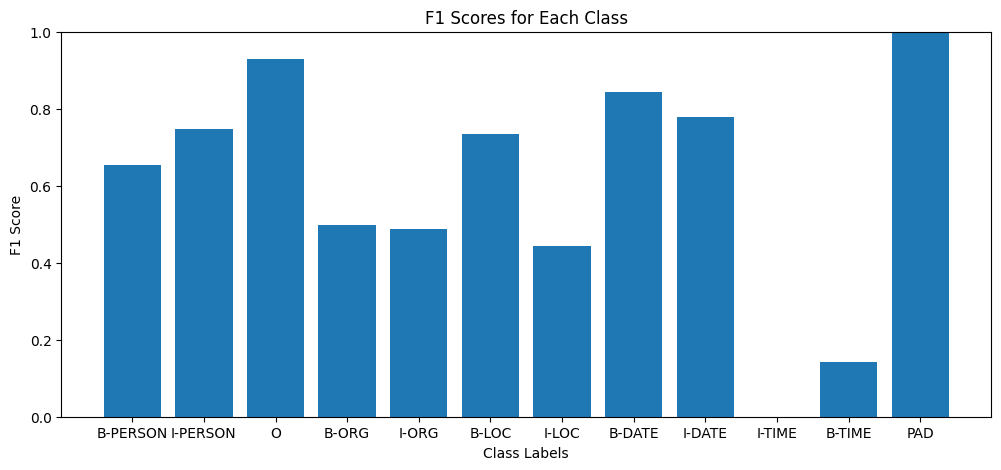

In [60]:
import matplotlib.pyplot as plt
f1 = f1_score(y_test.reshape(17802,1), preds.reshape(17802,1),average=None)
plt.figure(figsize=(12, 5))
plt.bar(tags, f1.tolist())
plt.xlabel('Class Labels')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.xticks(tags)
plt.ylim(0, 1)  # Optional: Set the y-axis limits
plt.show()